# Nonlin_scalar


In [23]:
%pylab inline
import scipy

from pyiga import bspline, assemble, geometry, solvers, vis

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\MHeig\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['f', 'grid']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [24]:
# define geometry
geo = geometry.quarter_annulus() #.rotate_2d(pi)
#geo = geometry.disk().translate([0.3,0.3])

# define isogeometric Taylor-Hood discretization space

p = 3     # spline degree of velocity space

# define discretization space (200 x 200 mesh, p=3)
kvs = 2 * (bspline.make_knots(3, 0.0, 1.0, 5),)

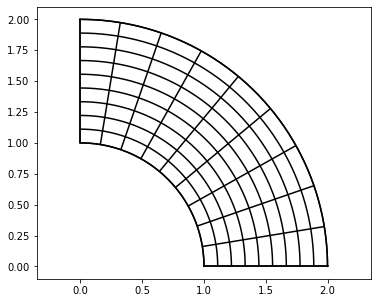

In [25]:
# undeformed quater annulus
figsize(6,5)
vis.plot_geo(geo, grid=2)

grid = geometry.outer_product(geometry.circular_arc(pi/2), geometry.line_segment(1, 2))
vis.plot_geo(grid)
axis('equal');

In [26]:
# compute Dirichlet boundary values
g = lambda x,y: (4*(0.25 - (1.5-y)**2))**7  # Dirichlet BC function at inflow boundary

bcs = assemble.compute_dirichlet_bcs(kvs, geo,
        [('top', g), ('left', 0)])
print(shape(bcs))


(2, 15)


In [27]:
#f = lambda x,y: 3 * np.sin(10*x) * np.cos(10*y) # source term
f = lambda x,y: 0.0
# compute right-hand side from function f
rhs = assemble.inner_products(kvs, f, f_physical=True, geo=geo).ravel()

print(shape(rhs))
#print(rhs)

(64,)


In [28]:
###########################
# solve Poisson Problem (for inital value)
# set up and solve linear system
A = assemble.stiffness(kvs,geo)
LS = assemble.RestrictedLinearSystem(A, rhs, bcs)

#u = scipy.sparse.linalg.spsolve(LS.A, LS.b)
#u_func = geometry.BSplineFunc(kvs, LS.complete(u))
#u= LS.complete(u)

u = LS.complete(solvers.make_solver(LS.A).dot(LS.b))
sol= [LS.restrict(u)] # to bcs

In [29]:
print(shape(sol))
print(shape(u))
#print(sol)
#print(u)
#print(sol[-1])

(1, 49)
(64,)


In [30]:
#u_func = geometry.BSplineFunc(kvs, u)
#print(u_func)

def get_bspline(u):
    """convert solution vector into B-spline function """
    return bspline.BSplineFunc(kvs, u)

In [31]:
dis = get_bspline(u)
print(dis)
# nonlinear term (functional)
#asm_nl= assemble.Assembler('inner((1+dis)*grad(dis), grad(v)) * dx', kvs, bfuns=[('v',1)], geo=geo, dis=dis, updatable=['dis'])

# linearized term  (matrix)
#asm_lin= assemble.Assembler('inner( (1+ u)*grad(dis) + (1+ dis)*grad(u) , grad(v)) * dx', 
#                            kvs, bfuns=[('u',1), ('v',1)], geo=geo, dis=dis, updatable=['dis'])

In [32]:
def apply_nl(dis):
    z = assemble.assemble('inner((1+dis)*grad(dis), grad(v)) * dx', kvs,
                          bfuns=[('v',1)], geo=geo, dis=dis)
    return z.ravel() # vector z

def linearized_el(u):
    dis = get_bspline(u)
    A_lin = assemble.assemble('inner( (1+ u)*grad(dis) + (1+ dis)*grad(u) , grad(v)) * dx', 
                              kvs, bfuns=[('u',1), ('v',1)], geo=geo, dis=dis) #matrix A
    return A_lin

def linearized_eq(u):
    dis = get_bspline(u)
    A_lin = assemble.assemble('inner( grad(u) + dis* grad(u) + u*grad(dis) , grad(v)) * dx', 
                              kvs, bfuns=[('u',1), ('v',1)], geo=geo, dis=dis) #matrix A
    return A_lin

In [33]:
x= sol[-1]
u_d = LS.complete(x) # u= u_d
#print(u_d)
#u==u_d

In [34]:
dd = shape(rhs)[0]
u= np.zeros(dd)

In [35]:
dis = get_bspline(u)

z= apply_nl(dis)
A_lin= linearized_el(u)
#A_lin= linearized_eq(u)

In [36]:
# solve linearized system 
### first iteration ###
LS = assemble.RestrictedLinearSystem(A_lin, rhs- z, bcs)   # rhs = 0 + 'old' a(u,v)
u = solvers.make_solver(LS.A).dot(LS.b)
print(shape(u))
u = LS.complete(u)
print(shape(u))
u_func = geometry.BSplineFunc(kvs, u)


(49,)
(64,)


In [37]:
print(u)
print(u_func)

[ 0.          0.00377993  0.01174482  0.01935527  0.02342338  0.02799006
  0.02645571  0.02677024  0.          0.00547029  0.00870843  0.01993697
  0.02763689  0.02113857  0.02916781  0.02819668  0.          0.00203136
  0.01956424  0.01964988  0.0199418   0.04159806  0.02728551  0.02906625
  0.          0.01165071  0.01279822  0.04141737  0.05794859  0.03634109
  0.05745186  0.05508038  0.          0.01092308  0.06552065  0.07130159
  0.07711934  0.13370546  0.0994771   0.10363229  0.          0.0532396
  0.07056024  0.18820765  0.24245235  0.14688411  0.22593038  0.21693685
  0.          0.03028686  0.26022598  0.37013812  0.30629408  0.38303988
  0.20449633  0.22156763  0.          0.03941552 -0.21120529  0.94397803
  0.94397803 -0.21120529  0.03941552  0.        ]


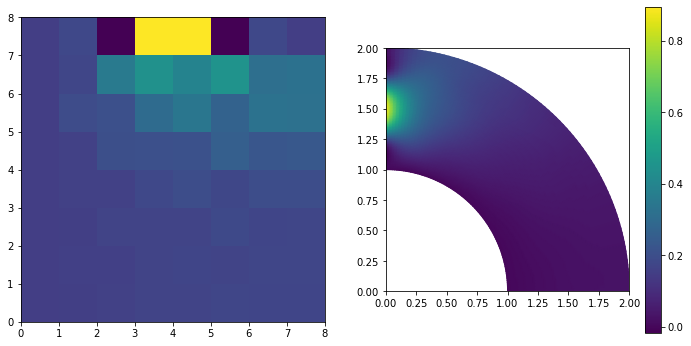

In [38]:
# plot coefficients and solution
figsize(12,6)

subplot(1,2,1)
pcolormesh(u_func.coeffs)
gca().set_aspect('equal')

subplot(1,2,2)
vis.plot_field(u_func, geo)
gca().set_aspect('equal')
colorbar();

In [39]:
dis = get_bspline(u)

# solve linearized system
### second iteration ###
LS = assemble.RestrictedLinearSystem(linearized_el(u), rhs-apply_nl(dis), bcs)   # rhs = 0 + 'old' a(u,v)
u_d = solvers.make_solver(LS.A).dot(LS.b)
u_d = LS.complete(u_d)

In [40]:
print(np.linalg.norm(u_d))
print(u_d)

2.859398070972818
[ 0.          0.02981583  0.08770522  0.1382864   0.16323267  0.1858102
  0.18011994  0.18142444  0.          0.03584929  0.07653014  0.13765371
  0.18049192  0.15671035  0.18860649  0.18473267  0.          0.02589757
  0.12277199  0.15088213  0.16070143  0.24837033  0.19821398  0.20469128
  0.          0.06693312  0.12188043  0.24349181  0.31159822  0.23951891
  0.30673584  0.29904846  0.          0.08487855  0.34041472  0.38838949
  0.40568202  0.55344793  0.46658206  0.47710137  0.          0.20508625
  0.38336897  0.57546935  0.6218024   0.38863731  0.53197569  0.51533327
  0.          0.15081527  0.79323591  0.68891136  0.56174253  0.78704784
  0.49294732  0.51916514  0.          0.03941552 -0.21120529  0.94397803
  0.94397803 -0.21120529  0.03941552  0.        ]


In [41]:
u = u+u_d
print(u)
u_func = geometry.BSplineFunc(kvs, u)

[ 0.          0.03359577  0.09945004  0.15764167  0.18665604  0.21380026
  0.20657565  0.20819468  0.          0.04131958  0.08523857  0.15759068
  0.2081288   0.17784892  0.21777429  0.21292935  0.          0.02792893
  0.14233622  0.17053201  0.18064323  0.2899684   0.22549949  0.23375753
  0.          0.07858382  0.13467865  0.28490918  0.36954681  0.27586001
  0.3641877   0.35412884  0.          0.09580162  0.40593537  0.45969108
  0.48280136  0.68715339  0.56605916  0.58073366  0.          0.25832585
  0.45392921  0.76367701  0.86425475  0.53552142  0.75790607  0.73227012
  0.          0.18110213  1.05346189  1.05904948  0.86803661  1.17008772
  0.69744365  0.74073277  0.          0.07883104 -0.42241058  1.88795606
  1.88795606 -0.42241058  0.07883104  0.        ]


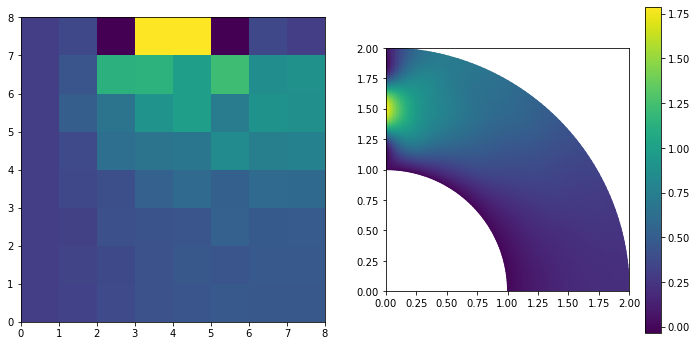

In [42]:
# plot coefficients and solution
figsize(12,6)

subplot(1,2,1)
pcolormesh(u_func.coeffs)
gca().set_aspect('equal')

subplot(1,2,2)
vis.plot_field(u_func, geo)
gca().set_aspect('equal')
colorbar();

In [43]:
dd = shape(rhs)[0]

0
1.6466343484698336
1.0776755290942437
1
2.859398070972818
2.7076833854801228
2
1.4292998121353295
5.1713351266206375
3
2.6539527691374674
7.514581225544303
4
1.944690516848277
11.964550289710226
5
5.365266304347288
15.254206540949529
[ 0.          0.12050898  0.33894107  0.50399485  0.55554031  0.63324722
  0.60527236  0.61037869  0.          0.14591353  0.28620403  0.46445837
  0.61266918  0.50167479  0.62098572  0.60752679  0.          0.13255824
  0.51542355  0.71132641  0.6675292   0.91938471  0.76352538  0.78143093
  0.          0.08100836  0.22720707  0.19899244  0.41330439  0.23478271
  0.42519554  0.40670877  0.          0.53246135  1.47900839  2.37217534
  1.86013429  2.19411412  1.79068085  1.83179981  0.         -0.2133815
  0.12111147  1.67714894  1.59693559  1.38802078  2.01125446  1.96680211
  0.         -0.3091466   3.10204058  4.20817454  1.98577067  4.14142047
  1.7125276   1.96086221  0.          0.23649311 -1.26723174  5.66386819
  5.66386819 -1.26723174  0.2364931

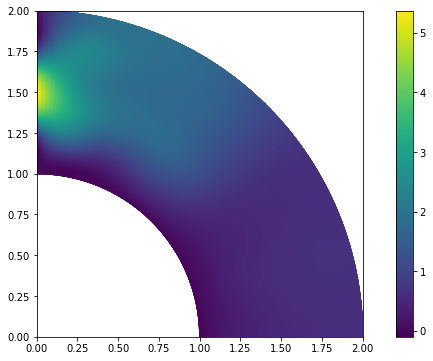

In [47]:
# solve linearized variational problem
#initial value
u= np.zeros(dd)
dis = get_bspline(u)
epsilon= 10^-6


#while True:
for i in range(6):
    print(i)
     # B-spline function, takes coeff u
    LS = assemble.RestrictedLinearSystem(linearized_el(u), rhs-apply_nl(dis), bcs)   # rhs = 0 + 'old' a(u,v)
    u_d = solvers.make_solver(LS.A).dot(LS.b)
    u_d = LS.complete(u_d) # value
    
    #update (u= u+ delta_u)
    u+= u_d
    #print(u)
   
    
    print(np.linalg.norm(u_d))
    print(np.linalg.norm(rhs-apply_nl(dis)))
    
    ### plot u
    vis.plot_field(get_bspline(u), geo)
    gca().set_aspect('equal')
   

    if np.linalg.norm(u_d) < epsilon:
        break
print(u)
colorbar();